## Import libaries

In [76]:
%pip install prophet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [77]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

# Time series
from prophet import Prophet

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [78]:
# Load train.csv
train = pd.read_csv('../data/raw/train.csv', parse_dates=['date'])
test = pd.read_csv('../data/raw/test.csv', parse_dates=['date'])

## Data Exploration

In [79]:
# Data Exploration
## Check dataset dimensions
print("Train shape:", train.shape)

## Show first rows of the training set
print("\nFirst rows of the training data:")
display(train.head())

## Check data types and null values
print("\nInfo about train dataset:")
print(train.info())

print("\nMissing values in train dataset:")
print(train.isnull().sum())

train.describe()

Train shape: (913000, 4)

First rows of the training data:


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10



Info about train dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None

Missing values in train dataset:
date     0
store    0
item     0
sales    0
dtype: int64


,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


#### Sale over time

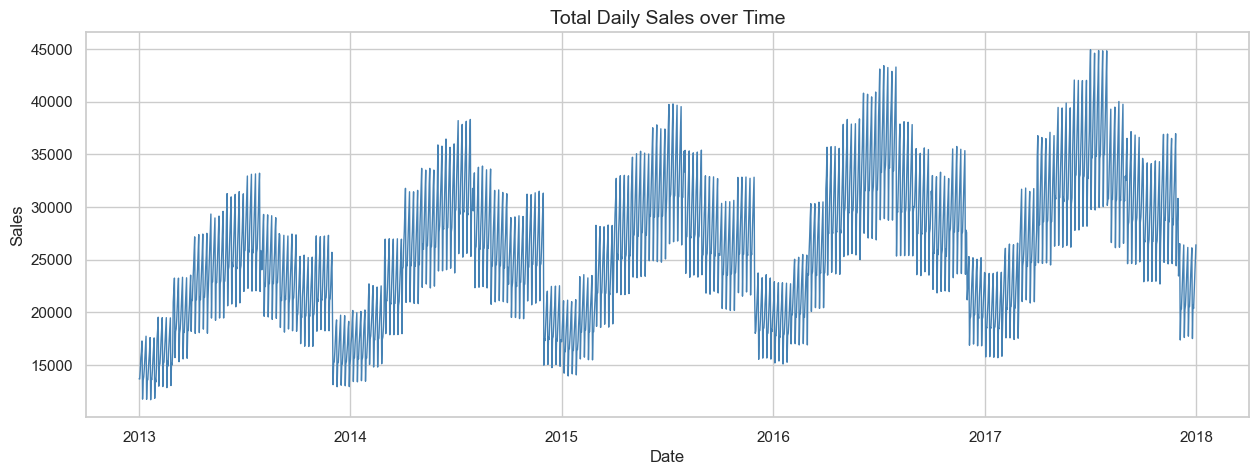

In [80]:
# Global Sales Trend
daily_sales = train.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(15,5))
plt.plot(daily_sales["date"], daily_sales["sales"], color="steelblue", linewidth=1)
plt.title("Total Daily Sales over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


### Month Sales Patterns

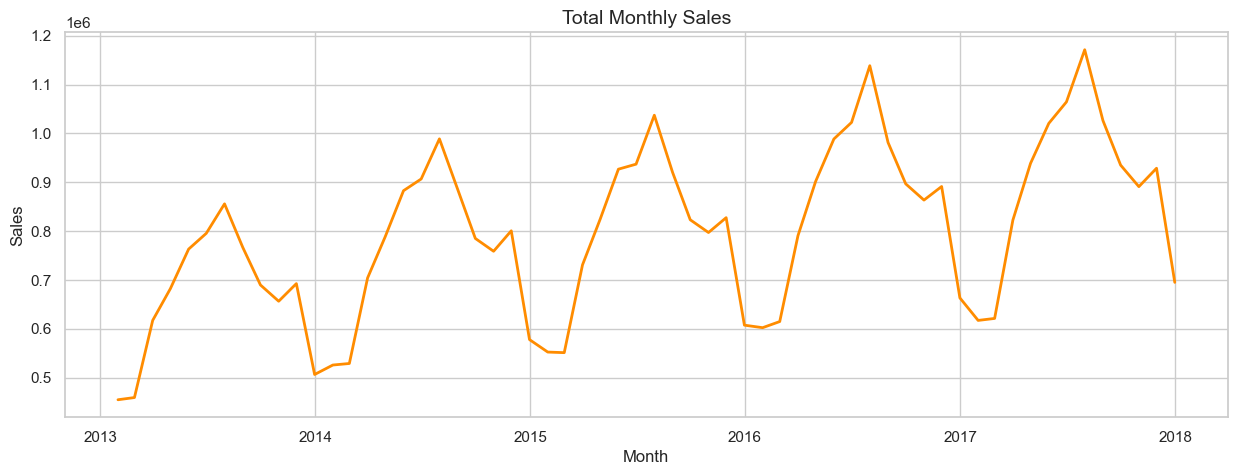

In [81]:
# Monthly Sales Aggregation
monthly_sales = train.set_index("date").resample("M")["sales"].sum()

plt.figure(figsize=(15,5))
plt.plot(monthly_sales.index, monthly_sales.values, color="darkorange", linewidth=2)
plt.title("Total Monthly Sales", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

### Weekly Sales Pattern

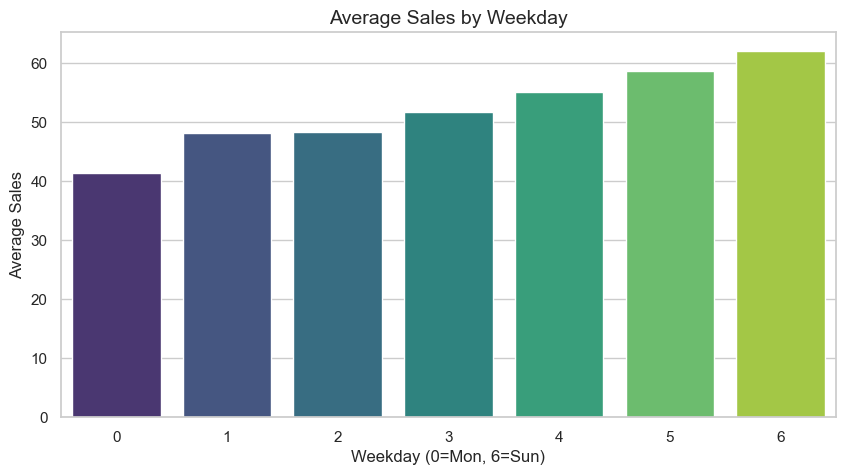

Average sales per weekday:
 weekdays
0    41.429638
1    48.225908
2    48.368506
3    51.723218
4    55.157249
5    58.662697
6    62.143333
Name: sales, dtype: float64


In [82]:
# Weekly Sales Pattern
## Add weekday column (0 = Monday, 6 = Sunday)
train["weekdays"] = train["date"].dt.dayofweek

# Average sales per weekday
weekday_sales = train.groupby("weekdays")["sales"].mean()

plt.figure(figsize=(10,5))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values, palette="viridis")
plt.title("Average Sales by Weekday", fontsize=14)
plt.xlabel("Weekday (0=Mon, 6=Sun)")
plt.ylabel("Average Sales")
plt.show()

print("Average sales per weekday:\n", weekday_sales)


### Store-Level Analysis

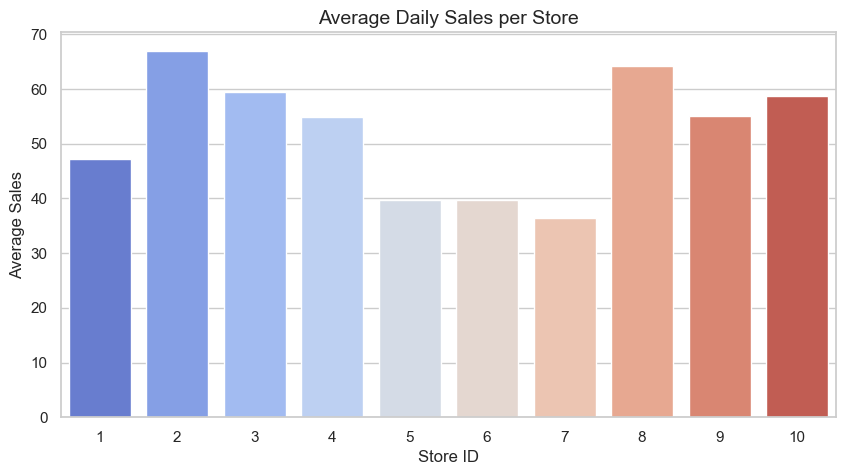

Average daily sales per store:
    store      sales
0      1  47.268379
1      2  67.033165
2      3  59.530602
3      4  54.902946
4      5  39.770164
5      6  39.733516
6      7  36.363735
7      8  64.142048
8      9  55.049025
9     10  58.709288


In [83]:
# Store-Level Sales Comparison
## Average daily saled per store
store_sales = train.groupby("store")["sales"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x="store", y="sales", data=store_sales, palette="coolwarm")
plt.title("Average Daily Sales per Store", fontsize=14)
plt.xlabel("Store ID")
plt.ylabel("Average Sales")
plt.show()

print("Average daily sales per store:\n", store_sales)

### Top 10 Item Overall

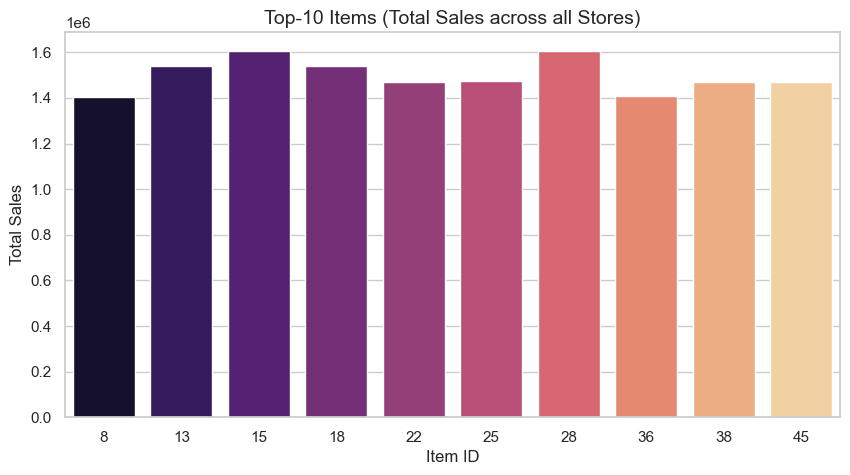

Top-10 items overall:
     item    sales
14    15  1607442
27    28  1604713
12    13  1539621
17    18  1538876
24    25  1473334
44    45  1471467
37    38  1470330
21    22  1469971
35    36  1406548
7      8  1405108


In [84]:
# Top 10 Items Overall
## Total sales per item (all store combined)
item_sales = train.groupby("item")["sales"].sum().reset_index()

# Top 10 items
top_items = item_sales.sort_values(by="sales", ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x="item", y="sales", data=top_items, palette="magma")
plt.title("Top-10 Items (Total Sales across all Stores)", fontsize=14)
plt.xlabel("Item ID")
plt.ylabel("Total Sales")
plt.show()

print("Top-10 items overall:\n", top_items)

## Top Selling Item per Store

In [85]:
# Top Item per Store

## Total sales per store-item combination
store_item_sales = train.groupby(["store","item"])["sales"].sum().reset_index()

## For each store, find the item with maximum sales
top_item_per_store = store_item_sales.loc[store_item_sales.groupby("store")["sales"].idxmax()]

print("Top-Selling Item per Store:")
display(top_item_per_store)

Top-Selling Item per Store:


,store,item,sales
14,1,15,145497
77,2,28,205677
114,3,15,183373
164,4,15,169186
214,5,15,122319
264,6,15,121737
314,7,15,111640
364,8,15,197295
414,9,15,170069
464,10,15,180757


### Heatmap of Store vs Item Sales


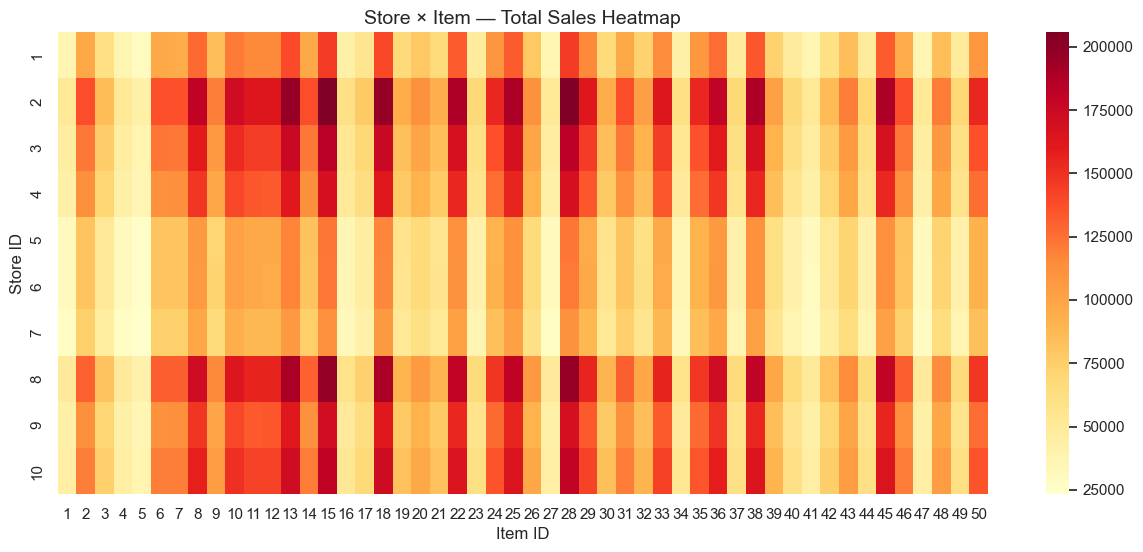

In [86]:
# Heatmap Store x Item
pivot_sales = train.pivot_table(index="store", columns="item", values="sales", aggfunc="sum")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_sales, cmap="YlOrRd", cbar=True)
plt.title("Store × Item — Total Sales Heatmap", fontsize=14)
plt.xlabel("Item ID")
plt.ylabel("Store ID")
plt.show()

Baseline Model (Mean Predictor)

In [87]:
# Train/validation split (time-based: last 3 months = validation)
cutoff_date = "2017-10-01"
train_baseline = train[train["date"] < cutoff_date]
val_baseline = train[train["date"] >= cutoff_date]

# Compute mean sales per (store, item) from training part
mean_sales = train_baseline.groupby(["store", "item"])["sales"].mean()

# Predict validation: use group mean (fallback to global mean if missing)
val_preds = val_baseline.set_index(["store", "item"]).index.map(
    lambda idx: mean_sales.get(idx, train_baseline["sales"].mean())
)

# True values
y_true = val_baseline["sales"].values
y_pred =np.array(val_preds)

# RMSLE
score = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"Baseline RMSLE: {score: .5f}")

Baseline RMSLE:  0.24273


In [88]:
# Lag features
data['lag_1'] = data['sales'].shift(1)
data['lag_7'] = data['sales'].shift(7)
data['rolling_7'] = data['sales'].shift(1).rolling(window=7).mean()

# Drop NaN after create lag
data = data.dropna()
data.head()


,date,store,item,sales,weekdays,day,month,weekday,lag_1,lag_7,rolling_7
21,2013-01-22,1,1,7,1,22,1,1,8.0,5.0,10.857143
22,2013-01-23,1,1,9,2,23,1,2,7.0,7.0,11.142857
23,2013-01-24,1,1,8,3,24,1,3,9.0,16.0,11.428571
24,2013-01-25,1,1,14,4,25,1,4,8.0,7.0,10.285714
25,2013-01-26,1,1,12,5,26,1,5,14.0,18.0,11.285714


In [89]:
# Train/val split 80%/20%
cutoff = int(len(data)*0.8)
train = data.iloc[:cutoff]
val = data.iloc[cutoff:]

X_train = train[['lag_1','lag_7','rolling_7','day','month','weekday']]
y_train = train['sales']

X_val = val[['lag_1','lag_7','rolling_7','day','month','weekday']]
y_val = val['sales']


05:35:30 - cmdstanpy - INFO - Chain [1] start processing
05:35:30 - cmdstanpy - INFO - Chain [1] done processing


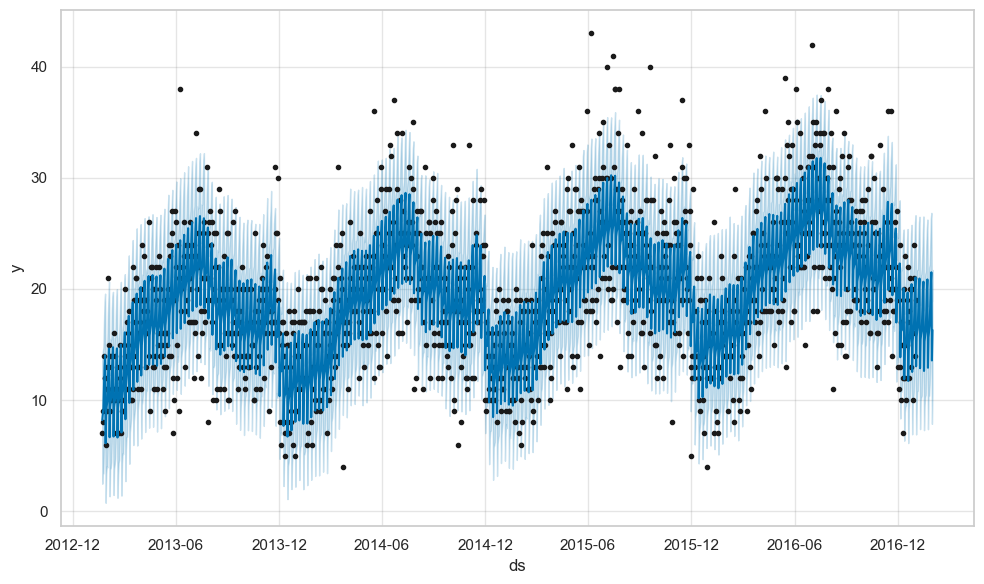

In [91]:
prophet_df = data[['date','sales']].rename(columns={'date':'ds','sales':'y'})
m = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m.fit(prophet_df)

future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

# Plot
m.plot(forecast)
plt.show()

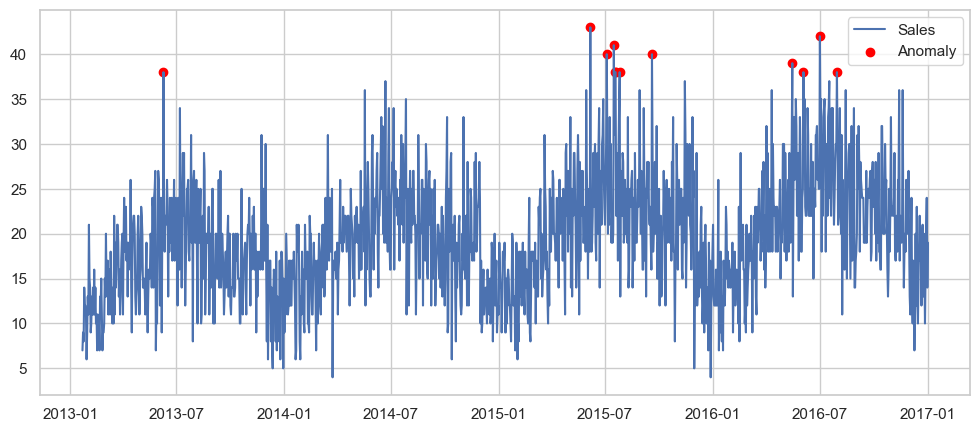

In [92]:
Q1 = data['sales'].quantile(0.25)
Q3 = data['sales'].quantile(0.75)
IQR = Q3 - Q1

data['anomaly'] = ((data['sales'] < (Q1 - 1.5*IQR)) | (data['sales'] > (Q3 + 1.5*IQR)))
plt.figure(figsize=(12,5))
plt.plot(data['date'], data['sales'], label='Sales')
plt.scatter(data['date'][data['anomaly']], data['sales'][data['anomaly']], color='red', label='Anomaly')
plt.legend()
plt.show()
